# FAOSTAT Case 5

In [34]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split

Load all the necessary libraries and functions.

In [ ]:
# Load file path
file_path = r"C:\\Users\\tssp4001\Desktop\\spartak\\fao_case\\fao_data_germany.xlsx"

# Load all sheet names
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

fs_3year = pd.read_excel(file_path, sheet_name=1)
fbs = pd.read_excel(file_path, sheet_name=0)

### Make a 3-year rolling mean for the FS dataset where there are values on 1 and 3 year basis

In [ ]:
# Make sure column is string
#fs["Year"] = fs["Year"].astype(str)
#
# Convert the target columns to numeric
#cols_to_avg = [
#    "Average dietary energy requirement (kcal/cap/day)",
#    "Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day)",
#    "Minimum dietary energy requirement  (kcal/cap/day)",
#    "Number of obese adults (18 years and older) (million)",
#     "Prevalence of obesity in the adult population (18 years and older) (percent)"
#]
#for col in cols_to_avg:
#    fs[col] = pd.to_numeric(fs[col], errors='coerce')
#
# Separate 1-year rows from 3-year period rows
#fs_1year = fs[~fs["Year"].str.contains("-")].copy()
#fs_3year = fs[fs["Year"].str.contains("-")].copy()
#
# Convert 1-year 'Year' column to int for comparison
#fs_1year["Year"] = fs_1year["Year"].astype(int)
#
# Compute 3-year averages
#for idx, row in fs_3year.iterrows():
#    try:
#        start_year, end_year = map(int, row["Year"].split("-"))
#        # Get the relevant rows from 1-year data
#        mask = fs_1year["Year"].between(start_year, end_year)
#        avg_values = fs_1year.loc[mask, cols_to_avg].mean()
#        fs_3year.loc[idx, cols_to_avg] = avg_values.values
#    except Exception as e:
#        print(f"Error at row {idx} ({row['Year']}): {e}")
#
# Reset index
#fs_3year = fs_3year.reset_index(drop=True)
#
# Preview result
#print(fs_3year[["Year"] + cols_to_avg].head())

Empty DataFrame
Columns: [Year, Average dietary energy requirement (kcal/cap/day), Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day), Minimum dietary energy requirement  (kcal/cap/day), Number of obese adults (18 years and older) (million), Prevalence of obesity in the adult population (18 years and older) (percent)]
Index: []


## Start modelling

### Make both datasets stationary

In [12]:
df = fbs.copy()
cols_to_check = df.columns[6:]  # columns to check for stationarity

# Function to run ADF test and return p-value
def adf_pvalue(series):
    series = series.dropna()
    if len(series) < 3:
        return None
    return adfuller(series)[1]

# Start with a copy of df
fbs_stationary = df.copy()

# Process each column
for col in cols_to_check:
    print(f"\nColumn: {col}")
    series = df[col]

    # Check original
    pval = adf_pvalue(series)
    print(f"  Original p-value: {pval}")
    if pval is not None and pval < 0.05:
        print("  -> Stationary (original)")
        continue  # keep original in fbs_stationary

    # First difference
    first_diff = series.diff()
    pval1 = adf_pvalue(first_diff)
    print(f"  First diff p-value: {pval1}")
    if pval1 is not None and pval1 < 0.05:
        print("  -> Stationary after first difference")
        fbs_stationary[col] = first_diff
        continue

    # Second difference
    second_diff = first_diff.diff()
    pval2 = adf_pvalue(second_diff)
    print(f"  Second diff p-value: {pval2}")
    if pval2 is not None and pval2 < 0.05:
        print("  -> Stationary after second difference")
        fbs_stationary[col] = second_diff
        continue

    # Third difference
    third_diff = second_diff.diff()
    pval3 = adf_pvalue(third_diff)
    print(f"  Third diff p-value: {pval3}")
    if pval3 is not None and pval3 < 0.05:
        print("  -> Stationary after third difference")
        fbs_stationary[col] = third_diff
    else:
        print("  -> Still non-stationary after third difference")
        fbs_stationary[col] = third_diff  # or keep as NaN if you prefer



Column: Total Losses (1000 t)
  Original p-value: 0.5208570995747439
  First diff p-value: 0.7587507804897552
  Second diff p-value: 0.0009473756755204744
  -> Stationary after second difference

Column: Fat supply quantity (g/capita/day)_Animal Products
  Original p-value: 0.27170026747650255
  First diff p-value: 0.604193869206636
  Second diff p-value: 0.5007002750915689
  Third diff p-value: 1.59474184688176e-09
  -> Stationary after third difference

Column: Fat supply quantity (g/capita/day)_Grand Total
  Original p-value: 0.9017942063745579
  First diff p-value: 0.011468068324780216
  -> Stationary after first difference

Column: Fat supply quantity (g/capita/day)_Vegetal Products
  Original p-value: 0.9910418979351029
  First diff p-value: 7.720915007588316e-05
  -> Stationary after first difference

Column: Food supply (kcal/capita/day)_Animal Products
  Original p-value: 0.9248458535492788
  First diff p-value: 5.968503223314696e-08
  -> Stationary after first difference

Co

In [ ]:
#fs_3year['Prevalence of undernourishment (percent) (3-year average)'] = fs_3year['Prevalence of undernourishment (percent) (3-year average)'].str.replace('<', '', regex=False)
#fs_3year['Prevalence of undernourishment (percent) (3-year average)'] = pd.to_numeric(fs_3year['Prevalence of undernourishment (percent) (3-year average)'], errors='coerce')

In [14]:
df = fs_3year.copy()
cols_to_check = df.columns[6:20]  # columns to check for stationarity

# Function to run ADF test and return p-value
def adf_pvalue(series):
    series = series.dropna()
    if len(series) < 3:
        return None
    return adfuller(series)[1]

# Create new DataFrame to store stationary versions
fs_3year_stationary = df.copy()

# Loop through columns and apply differencing as needed
for col in cols_to_check:
    print(f"\nColumn: {col}")
    series = df[col]

    # Check original
    pval = adf_pvalue(series)
    print(f"  Original p-value: {pval}")
    if pval is not None and pval < 0.05:
        print("  -> Stationary (original)")
        continue  # keep original

    # First difference
    first_diff = series.diff()
    pval1 = adf_pvalue(first_diff)
    print(f"  First diff p-value: {pval1}")
    if pval1 is not None and pval1 < 0.05:
        print("  -> Stationary after first difference")
        fs_3year_stationary[col] = first_diff
        continue

    # Second difference
    second_diff = first_diff.diff()
    pval2 = adf_pvalue(second_diff)
    print(f"  Second diff p-value: {pval2}")
    if pval2 is not None and pval2 < 0.05:
        print("  -> Stationary after second difference")
        fs_3year_stationary[col] = second_diff
        continue

    # Third difference
    third_diff = second_diff.diff()
    pval3 = adf_pvalue(third_diff)
    print(f"  Third diff p-value: {pval3}")
    if pval3 is not None and pval3 < 0.05:
        print("  -> Stationary after third difference")
        fs_3year_stationary[col] = third_diff
    else:
        print("  -> Still non-stationary after third difference")
        fs_3year_stationary[col] = third_diff  # optional fallback



Column: Total Losses (1000 t)
  Original p-value: 0.6073416449112722
  First diff p-value: 0.05243758318761879
  Second diff p-value: 0.0077613755104974065
  -> Stationary after second difference

Column: Fat supply quantity (g/capita/day)_Animal Products
  Original p-value: 0.00025634480826622113
  -> Stationary (original)

Column: Fat supply quantity (g/capita/day)_Grand Total
  Original p-value: 0.9372925449145967
  First diff p-value: 0.01790059516609573
  -> Stationary after first difference

Column: Fat supply quantity (g/capita/day)_Vegetal Products
  Original p-value: 0.929366054884032
  First diff p-value: 0.002228226669643213
  -> Stationary after first difference

Column: Food supply (kcal/capita/day)_Animal Products
  Original p-value: 0.954898610557499
  First diff p-value: 0.22512843743003197
  Second diff p-value: 0.0430189374689524
  -> Stationary after second difference

Column: Food supply (kcal/capita/day)_Grand Total
  Original p-value: 0.03502319378353599
  -> Sta

All desired values are being converted to stationary above. This is a needed measure because we aim for constant mean and variance which is crucial for time series. We hope this has postive impact over the calculations of OLS regression and Lasso. Later, we will observe whether the dependent variables are significant for predicting obesity in the society. By doing that, we strive to avoid biased coefficients. 

We can see that some variables are already stationary at the beginning. However, some would need to be transformed with their first/second/third difference to become stationary. Then, the new values are obtained.

In [17]:
# Save both as csv for checks 
fbs_stationary.to_csv('fbs_stationary_germany_last.csv', index=False)
fs_3year_stationary.to_csv('fs_3year_stationary_germany_last.csv', index=False)

### Drop some columns (Food Losses (1000t), Population)

In [18]:
fbs_stationary = fbs_stationary.drop(columns=["Total Losses (1000 t)", "Population (1000no)"])

The population and total food losses in 1000t wouldn't be useful for us so we decide to remove those columns before we start with our modelling.

### Check correlations and drop correlated factors with above 80% (but without food losses)

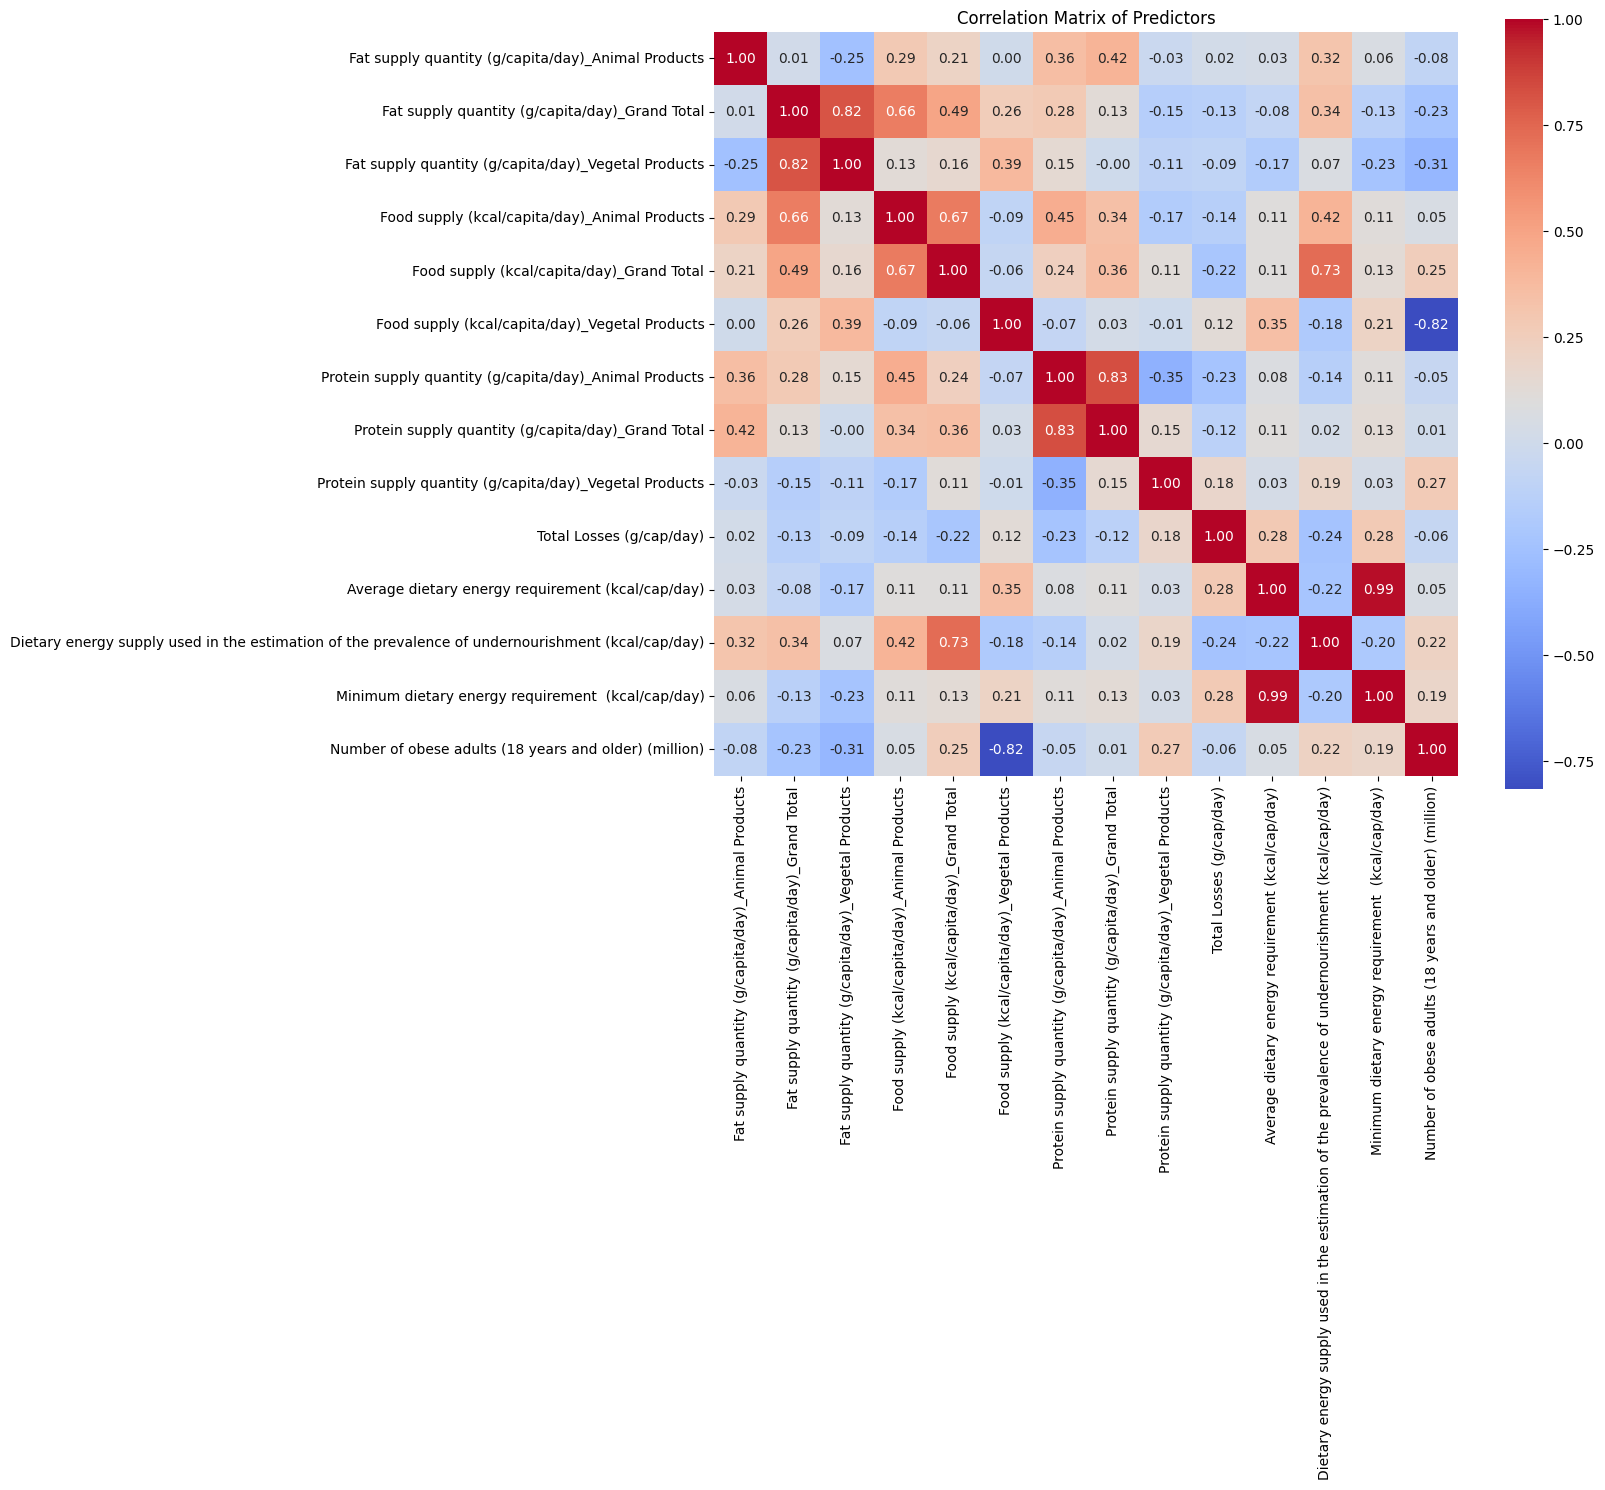

In [20]:
# Drop metadata and target
cols_to_exclude = ['Domain Code', 'Domain', 'Area Code', 'Area', 'Year Code', 'Year', 'Prevalence of obesity in the adult population (18 years and older) (percent)']
X = fbs_stationary.drop(columns=cols_to_exclude, errors='ignore').select_dtypes(include='number')

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Predictors")
plt.show()

After checking the correlation between the independent variables, we observe we have big positive relationships. This seems logical because the columns we have are conveying similar meaning. That's the reason why we remove the redundant ones because multicolinearity might be problematic for our results.

In [21]:
protected_column = "Prevalence of obesity in the adult population (18 years and older) (percent)"

# Compute correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop, skipping the protected one
to_drop = []
for column in upper.columns:
    if column == protected_column:
        continue  # Skip dropping this one
    if any(upper[column] > 0.8):
        to_drop.append(column)

print("❌ Dropping due to high correlation (except protected):")
print(to_drop)

# Drop selected columns
X_uncorrelated = X.drop(columns=to_drop)

❌ Dropping due to high correlation (except protected):
['Fat supply quantity (g/capita/day)_Vegetal Products', 'Protein supply quantity (g/capita/day)_Grand Total', 'Minimum dietary energy requirement  (kcal/cap/day)', 'Number of obese adults (18 years and older) (million)']


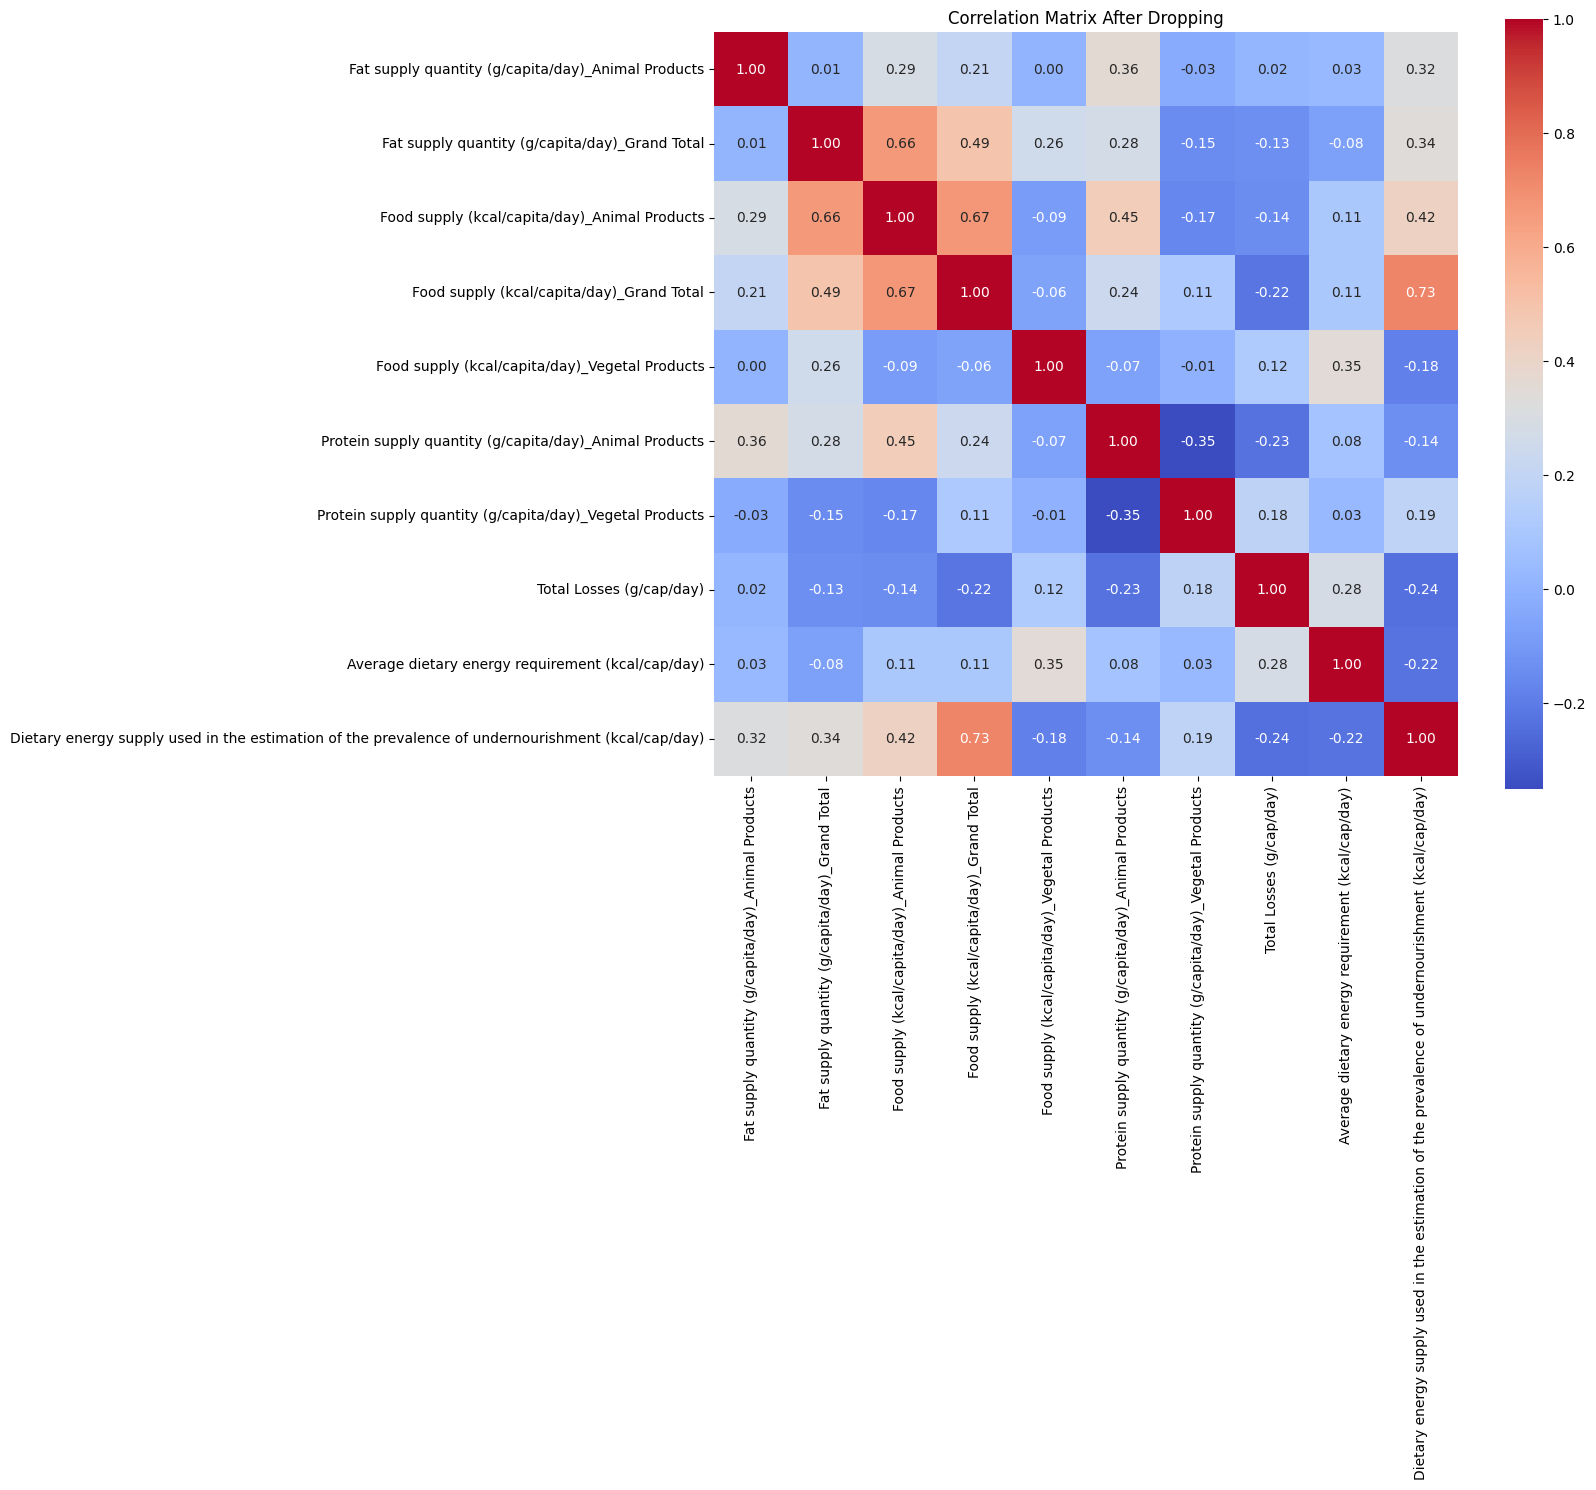

In [22]:
# Plot new heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_uncorrelated.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix After Dropping")
plt.show()

### Now run OLS regression to check coefficients 

In [23]:
# Your target variable
y = fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Drop rows with any missing values in predictors or target
data = pd.concat([X_uncorrelated, y], axis=1).dropna()

# Define cleaned X and y
X_clean = data.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)']).astype(float)
y_clean = data['Prevalence of obesity in the adult population (18 years and older) (percent)'].astype(float)

# Add constant for intercept
X_const = sm.add_constant(X_clean)

# Fit the OLS model
ols_model = sm.OLS(y_clean, X_const).fit()

# Show regression summary
print(ols_model.summary())

# Check multicollinearity via VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("\n📊 Variance Inflation Factors (VIF):")
print(vif_data)

                                                         OLS Regression Results                                                         
Dep. Variable:     Prevalence of obesity in the adult population (18 years and older) (percent)   R-squared:                       0.947
Model:                                                                                      OLS   Adj. R-squared:                  0.888
Method:                                                                           Least Squares   F-statistic:                     16.01
Date:                                                                          Sat, 28 Jun 2025   Prob (F-statistic):           0.000147
Time:                                                                                  15:32:22   Log-Likelihood:                 18.732
No. Observations:                                                                            20   AIC:                            -15.46
Df Residuals:                            

When we run linear regression with OLS, we can see that all the values except one are not statistically significant therefore there is no direct linear connection between them and obesity. Only Food supply (kcal/capita/day)_Vegetal Products can be interpreted to have direct influence on obesity.  F-statistic p-value = 0.000147 means that the model is overall statistically significant although there is only 1 such variable. The model explains about 94.7% of the variance in adult obesity prevalence, which is very high.

### Now run Lasso to check weights when predicting food losses

In [37]:
# Drop first 6 columns + target column from predictors
excluded_cols = fbs_stationary.columns[:6].tolist() + [
    'Prevalence of obesity in the adult population (18 years and older) (percent)',
    'Number of obese adults (18 years and older) (million)'
]
X_lasso = fbs_stationary.drop(columns=excluded_cols)

# Drop rows with missing values
df_lasso = pd.concat([X_lasso, fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']], axis=1).dropna()
X_lasso_clean = df_lasso.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)'])
y_lasso = df_lasso['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Create and fit the Lasso pipeline
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42)
)
lasso_pipeline.fit(X_lasso_clean, y_lasso)

# Extract the trained LassoCV model
lasso_model = lasso_pipeline.named_steps['lassocv']

# Show selected alpha
print(f"🔧 Best alpha: {lasso_model.alpha_:.5f}")

# Get coefficients
lasso_coef = pd.Series(lasso_model.coef_, index=X_lasso_clean.columns)
selected_features = lasso_coef[lasso_coef != 0].sort_values(ascending=False)

# Print results
print("\n✅ Selected Features (non-zero coefficients):")
print(selected_features)

print("\n❌ Dropped Features (coefficients = 0):")
print(lasso_coef[lasso_coef == 0].index.tolist())

🔧 Best alpha: 0.00135

✅ Selected Features (non-zero coefficients):
Food supply (kcal/capita/day)_Vegetal Products                                                       0.413098
Food supply (kcal/capita/day)_Animal Products                                                        0.115110
Protein supply quantity (g/capita/day)_Grand Total                                                   0.034504
Total Losses (g/cap/day)                                                                             0.028469
Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day)    0.015306
Fat supply quantity (g/capita/day)_Animal Products                                                  -0.023951
Fat supply quantity (g/capita/day)_Grand Total                                                      -0.047991
Minimum dietary energy requirement  (kcal/cap/day)                                                  -0.079939
Food supply (kcal/capita/day)_Grand Total           

C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.405e-05, tolerance: 1.175e-05
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e-05, tolerance: 1.175e-05
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feat

The strongest positive driver is Food supply (kcal/capita/day) Vegetal Product. Higher plant-based energy supply is associated with higher obesity prevalence. That could be also observed in the linear regression. The Food supply (kcal/capita/day) from Animal Products and obesity relationship is also positive link — more animal-based calories means more obesity. 

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_65756\1419078544.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\tssp4001\AppData\Local\Temp\ipykernel_65756\1419078544.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


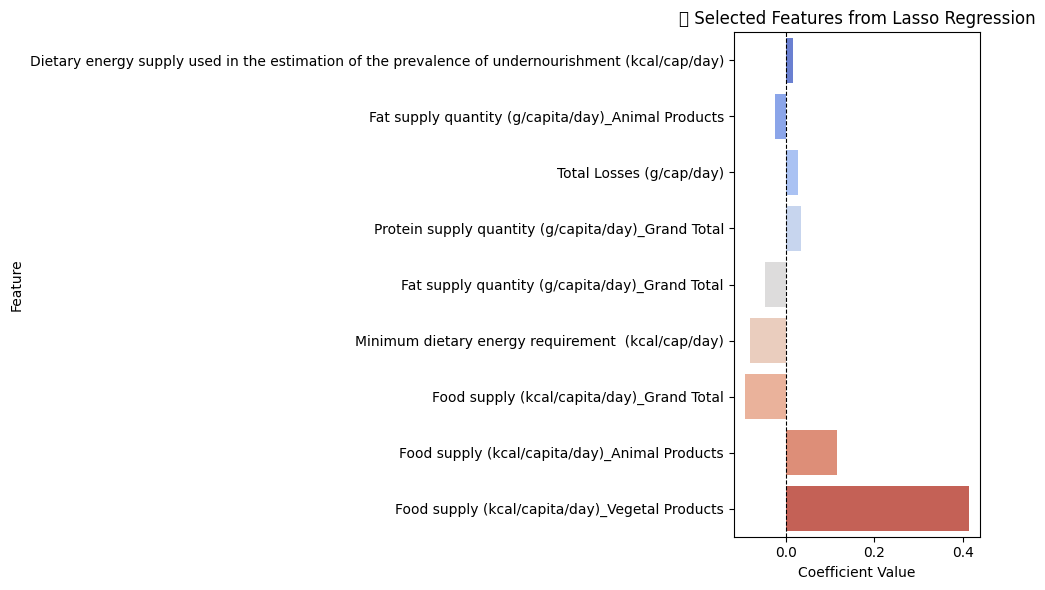

In [38]:
# Prepare data
selected_features_sorted = selected_features.sort_values(key=abs, ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=selected_features_sorted.values,
    y=selected_features_sorted.index,
    palette='coolwarm',
    orient='h'
)
plt.title('🔍 Selected Features from Lasso Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

### Now run Random Forest to obtain predictors related to food losses

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_65756\3756936689.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted, y=importances_sorted.index, palette="viridis")
C:\Users\tssp4001\AppData\Local\Temp\ipykernel_65756\3756936689.py:23: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


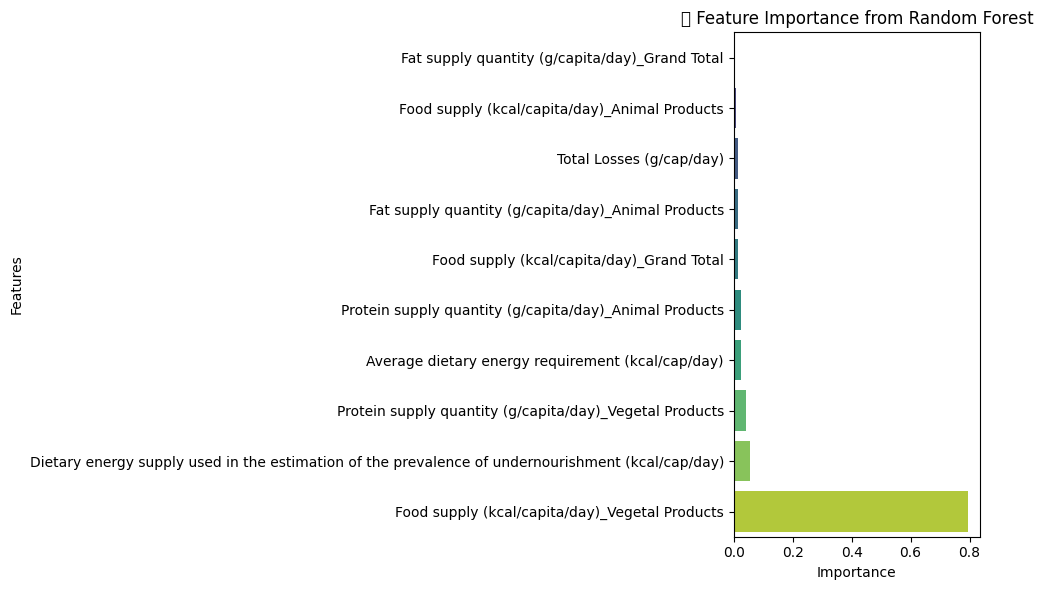

In [39]:
# Target variable
y_rf = fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Drop rows with missing values (only where needed)
df_rf = pd.concat([X_uncorrelated, y_rf], axis=1).dropna()
X_rf_clean = df_rf.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)'])
y_rf_clean = df_rf['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_clean, y_rf_clean)

# Feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_rf_clean.columns)
importances_sorted = importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted, y=importances_sorted.index, palette="viridis")
plt.title("🌲 Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_65756\981965292.py:14: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


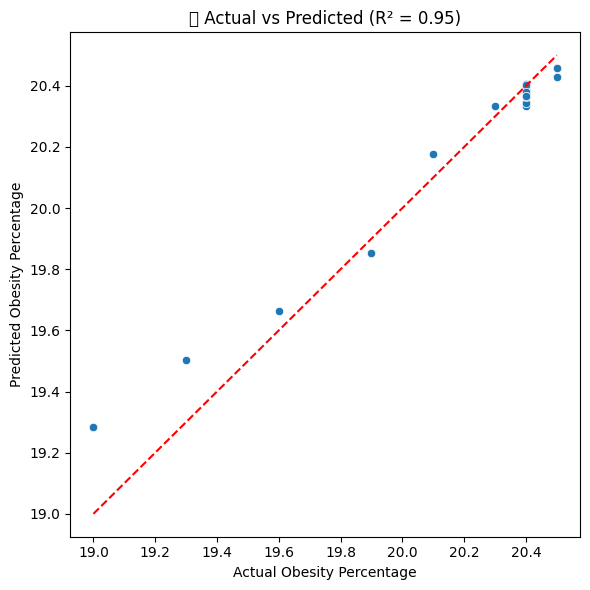

In [40]:
# Predictions
y_pred = rf_model.predict(X_rf_clean)

# R² score
r2 = r2_score(y_rf_clean, y_pred)

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_rf_clean, y=y_pred)
plt.plot([y_rf_clean.min(), y_rf_clean.max()], [y_rf_clean.min(), y_rf_clean.max()], 'r--')
plt.xlabel("Actual Obesity Percentage")
plt.ylabel("Predicted Obesity Percentage")
plt.title(f"🎯 Actual vs Predicted (R² = {r2:.2f})")
plt.tight_layout()
plt.show()

Food supply (kcal/capita/day) Vegetal Products once again has the highest predictive power with 0.78. This was also seen in the previous two models. The other coefficients are much less which means the vegetal products shape the obesity. This thesis is confirmed once again. The R^2 here explaining variance is 0.95 and is pretty much the same as the linear regression.